# Analyze Blast Results : Gulf of California Data COI

1. Look at sequence similarity between USEARCH and BANZAI contigs


In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

#For illustrator import:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
#Functions

#Raw Read Numbers
def make_rawread(infile):
    #infile = OTU_table_taxa_all.txt
    df = pd.read_csv(infile, sep='\t')
    df.rename(columns={'DUP_ID':'OTU'}, inplace=True)
    df.drop('taxonomy', axis=1, inplace=True)
    df.drop('repseq', axis=1, inplace=True)
    df.set_index('OTU', inplace=True)
    return df
    
#metadata handling and sample order
def make_metadata(infile):
    df = pd.read_csv(infile)
    #make all column names with underscore
    columns_l = list(df)
    columns_l = [c.replace('-', '_') for c in columns_l]
    df.columns = columns_l
    #extract site name
    df['site'] = df['sample_name'].str.extract('([a-zA-Z0-9]+)')
    df_full = df[:]
    #add in some missing location data
    df_full.loc[df_full['site']=='UC5', 'dec_lat'] = 32
    df_full.loc[df_full['site']=='UC5', 'dec_long'] = '.118.17'
    df_full['dec_long'] = df_full['dec_long'].str.replace('^\.','-')
    df_full.set_index('sample_name', inplace=True)
    df= df[['Description', 'Treatment', 'sample_name']]
    df['comb'] = df['Description']+'_'+df['Treatment']+'_'+df['sample_name']
    df['site_Order']=df['sample_name'].str.replace('GOC2a', '16').str.replace('GOC2b', '17').str.replace('NTC', '0')
    df['site_Order']=df['site_Order'].str.extract('(\d+)')
    df.set_index('sample_name', inplace=True)
    df['site_Order']= df['site_Order'].astype(int)
    df.sort_values('site_Order', ascending=True, inplace=True)
    return df_full, df

#DESEQ Numbers
def make_deseq(infile):
    df = pd.read_csv(infile, sep=',')
    df.rename(columns={'Unnamed: 0':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    return df

#Rarefied Read Numbers (From R script); make compositional
def make_rarereads_comp(infile):
    df= pd.read_csv(infile, sep=',')
    df.rename(columns={'Unnamed: 0':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    df=df.T
    df['Total']=df.sum(axis=1)
    tot_reads = df['Total'].tolist()
    tot_reads = set(tot_reads)
    print('Rarefied read count:', tot_reads)
    tot_reads = df['Total'].tolist()[0]
    df = df/tot_reads *100
    df.drop('Total', axis=1, inplace=True)
    df=df.T
    return df

def make_rarereads(infile):
    df= pd.read_csv(infile, sep=',')
    df.rename(columns={'Unnamed: 0':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    return df

#Taxa table
def make_taxa(infile):
    #infile = OTU_table_taxa_all.txt
    df = pd.read_csv(infile, sep='\t')
    df.rename(columns={'DUP_ID':'OTU'}, inplace=True)
    df = df[['taxonomy', 'OTU']]
    df.set_index('OTU', inplace=True)
    df['Kingdom']=df['taxonomy'].str.split("\'").str[1]
    df['Phylum']=df['taxonomy'].str.split("\'").str[3]
    df['Class']=df['taxonomy'].str.split("\'").str[5]
    df['Order']=df['taxonomy'].str.split("\'").str[7]
    df['Family']=df['taxonomy'].str.split("\'").str[9]
    df['Genus']=df['taxonomy'].str.split("\'").str[11]
    df['Species']=df['taxonomy'].str.split("\'").str[13]
    df=df.drop('taxonomy', axis=1)
    return df

#Filtered Taxa table
def make_Ftaxa(infile):
    df = pd.read_csv(infile, sep=',')
    df.rename(columns={'OTU_ID':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    df=df[df.columns[-7:]]
    return df

#extract sequences
def make_seq(infile):
    #infile = OTU_table_taxa_all.txt
    df = pd.read_csv(infile, sep='\t')
    df.rename(columns={'DUP_ID':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    df=df[['repseq']]
    return df

# Import Banzai Results

In [5]:
#COI M6
print('COI')
#OTU_table_taxa_all.txt location
file_loc1 = '/Users/kpitz/Projects/Gulf_of_California/Cutadapt_Results/COI/Analysis_20190921_1416/all_lib/Post_Blast_20190925_0914/OTU_table_taxa_all.txt'
#metadata
meta_file = '/Users/kpitz/Projects/Gulf_of_California/Cutadapt_Results/COI/Analysis_20190921_1416/GOC_20190921_1416_COI_analysis_metadata.csv'
#DESEQ data
#file2 = '/Users/kpitz/Projects/Gulf_of_California/Deseq/COI_GOC_DEseq_122117.csv'
#rarefied data
#file3 = '/Users/kpitz/Projects/MBON/Rarefied_Data_unmerged/GOC_COI_OTU_Table_071018_M6.csv'
#Filtered OTU table
file4 ='/Users/kpitz/Projects/Gulf_of_California/Cutadapt_Results/COI/Analysis_20190921_1416/all_lib/Filtered_OTU_taxa_table_all.csv'

raw_COI = make_rawread(file_loc1)
meta_COI, samp_lim_COI = make_metadata(meta_file)
#deseq_COI = make_deseq(file2)
#rare_COI = make_rarereads(file3)
#rare_comp_COI = make_rarereads_comp(file3)
taxa_COI = make_taxa(file_loc1)
Ftaxa_COI = make_Ftaxa(file4)
seq_COI = make_seq(file_loc1)

#Directory for saving Figures
plot_dir = '/Users/kpitz/Projects/Gulf_of_California/GOC_18S_COI_Combined_Cutadapt/'
plot_name = 'GOC_18SCOI_'
Plot_str = plot_dir + plot_name
print(Plot_str)

#Use to change the name of the databases
name1 = 'GOC_18SCOI_'

COI
/Users/kpitz/Projects/Gulf_of_California/GOC_18S_COI_Combined_Cutadapt/GOC_18SCOI_


# Import Filtered Banzai Results

Created in GOC_COI_Filter_Data.ipynb

- /Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_seq_table_092519.csv
- /Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_otu_table_092519.csv
- /Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_taxa_table_092519.csv

In [6]:
files = ['/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_seq_table_092519.csv',
         '/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_otu_table_092519.csv',
         '/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_taxa_table_092519.csv']
#dfs = [seq_COI_filt, raw_COI_filt, Ftaxa_COI_filt]
df = pd.read_csv(files[0])
df.set_index('Unnamed: 0', inplace=True)
df.index.rename('OTU', inplace=True)
seq_COI_filt = df.copy()

df = pd.read_csv(files[1])
df.set_index('Unnamed: 0', inplace=True)
df.index.rename('OTU', inplace=True)
raw_COI_filt = df.copy()

df = pd.read_csv(files[2])
df.set_index('Unnamed: 0', inplace=True)
df.index.rename('OTU', inplace=True)
Ftaxa_COI_filt = df.copy()

df.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species
OTU,,,,,,,
OTU_1,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Calanidae,Calanus,Calanus pacificus
OTU_10,Eukaryota,Cnidaria,Hydrozoa,Anthoathecata,Pandeidae,Pandea,s_
OTU_100,Eukaryota,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Nematoscelis,s_
OTU_100021,Eukaryota,Mollusca,Gastropoda,unknown,Cerithiidae,g_,s_
OTU_100022,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Aetideidae,g_,s_


# Import USEARCH Data

In [7]:
#rarefied datasets
Geller_18S = pd.read_csv('/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/18S_Geller_MGmodified_9Jan19.txt', sep='	')
Geller_18S
#original 18S before mistake fixed (OTU_67 included and taxonomy wrong- sequences also wrong)
#Geller_18So = pd.read_csv('/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/Incorrect_18S/18S_Geller.txt', sep='	')
#Geller_18So
Geller_COI = pd.read_csv('/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/COI_Geller.txt', sep='	')
Geller_COI

#non-rarefied datasets
file= '/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/Not_rarefied/MBARI_18S_otu_table_10097_txt.txt'
Geller_18S_nr = pd.read_csv(file, sep='	')
Geller_18S_nr
file= '/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/Not_rarefied/MBARI_COI_otu_table_10095_txt.txt'
Geller_COI_nr = pd.read_csv(file, sep='	')
Geller_COI_nr.head()




,#OTU ID,CP23_1,CP23_2,CP23,GOC2a,GOC2b,UC10,UC12,UC13,UC14,...,UC1,UC2,UC3_1,UC3_2,UC3,UC4,UC5,UC6,UC7,UC9
0,OTU_659,56525,9789,50014,0,0,0,4,9,90,...,0,0,2,1,0,9,0,0,0,9
1,OTU_187,2464,93987,3134,0,0,0,19,0,1,...,0,10,1,0,0,0,0,0,0,0
2,OTU_183,477,236,590,2,40,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,OTU_388,23844,4576,23573,0,0,0,1,3,47,...,3,10,2248,186,6090,5,0,0,0,3
4,OTU_1058,1050,1499,1015,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Import Blast Results

# Parse Blastn XML files

In [8]:
from Bio.Blast import NCBIXML

In [9]:
#Banzai data as a query, USEARCH data as the database
#filename = '/Users/kpitz/Projects/Gulf_of_California/Geller_MB_blastn/Gellerquery_MBdb_COI_blastn_092419.xml'
filename = '/Users/kpitz/Projects/Gulf_of_California/Geller_MB_blastn/MBquery_Gellerdb_COI_blastn_092419.xml'

result_handle =open(filename)
blast_records= NCBIXML.parse(result_handle)
#Dictionary to store hits
hit_dict ={}
for blast_record in blast_records:
    #query = blast_record.query.split('|')[1]
    query = blast_record.query
    #print(query)
    hit_ID=0
    for alignment in blast_record.alignments:
        hit_ID+=1       #hit ID counter
        if hit_ID >20:
            continue
        key = (query, hit_ID)
        hsp = alignment.hsps[0] #only look at top hsp
        #set limits on evalue and bitscore and % Identity
        per_iden = hsp.identities/float(hsp.align_length)
        per_iden = (per_iden *100)
        per_iden = round(per_iden, 2)
        evalue = hsp.expect
        bitscore = int(hsp.bits)
        #alignment length
        align_len = hsp.align_length
        
        value = (evalue, bitscore, per_iden, alignment.hit_def, align_len)
        hit_dict[key]=value

print ('Done parsing Blast xml File!')
#Save blast result stats to file
Blast_Results = pd.DataFrame(hit_dict)
Blast_Results=Blast_Results.T
Blast_Results.columns = ['eval','bitscore', '%ID', 'hit_def', 'align_len']

MBq = Blast_Results.copy()
MBq


Done parsing Blast xml File!


eval bitscore    %ID  \
DUP_100021;size=4 1   3.04748e-150      523  96.81   
                  2    4.29145e-89      320  85.39   
                  3    7.65321e-42      163  77.11   
                  4    2.75258e-41      161  76.49   
                  5    9.97034e-36      143  75.42   
                  6    3.58597e-35      141  77.33   
                  7    4.63875e-34      137  75.17   
                  8     6.0432e-28      117   75.1   
                  9    2.17352e-27      115   75.3   
                  10   7.81737e-27      113  74.44   
                  11   7.81737e-27      113   75.1   
                  12   2.81163e-26      111  75.32   
                  13   1.01842e-20       93  76.97   
                  14   4.73825e-19       87  96.23   
                  15   6.12931e-18       84  73.85   
                  16   1.02565e-15       76  89.83   
                  17   2.87194e-11       62  92.86   
DUP_100022;size=4 1   3.04748e-150      523  96.82   
                  2   1.42792e-143      501  95.53   
                  3   2.38942e-141      494  95.21   
                  4   2.38942e-141      494  95.21   
                  5   2.38942e-141      494  95.21   
                  6   3.99834e-139      486  94.86   
                  7   1.43806e-138      484  94.57   
                  8   1.11958e-134      472  93.93   
                  9   4.02673e-134      470  94.25   
                  10   5.2089e-133      466  93.63   
                  11  1.87345e-132      464  93.15   
                  12  6.73814e-132      462  93.29   
                  13  6.73814e-132      462  94.08   
...                            ...      ...    ...   
DUP_99998;size=4  13    2.458e-121      427  91.37   
                  14  3.17962e-120      424  91.05   
                  15   1.1436e-119      422  91.08   
                  16  1.47933e-118      418  91.45   
                  17  5.32063e-118      416  90.73   
                  18  6.88267e-117      412  90.42   
                  19  6.88267e-117      412  90.51   
                  20  2.47545e-116      411  90.42   
DUP_999;size=449  1   2.99512e-155      540  98.06   
                  2    1.25865e-44      172  77.15   
DUP_9;size=60137  1   6.41258e-167      579    100   
                  2    8.9033e-116      409  90.35   
                  3    4.23116e-99      353  87.58   
                  4    1.99662e-87      315  84.89   
                  5    5.59075e-83      300  84.72   
                  6    2.63819e-71      261  82.65   
                  7    9.48862e-71      259  81.85   
                  8    2.08319e-57      215  80.43   
                  9    5.91629e-43      167  76.58   
                  10   2.12788e-42      165  76.95   
                  11   2.12788e-42      165  78.02   
                  12   9.90005e-41      159  77.11   
                  13   2.77213e-36      145  76.31   
                  14   9.97034e-36      143  75.59   
                  15   4.63875e-34      137   82.1   
                  16   1.66839e-33      135  82.17   
                  17   1.66839e-33      135  84.17   
                  18    6.0006e-33      134  82.67   
                  19    2.1582e-32      132  81.37   
                  20   7.76227e-32      130  81.53   

                                                                hit_def  \
DUP_100021;size=4 1       Geller_COI|OTU_96|462|NaN_NaN_NaN_NaN_NaN_NaN   
                  2     Geller_COI|OTU_1355|475|NaN_NaN_NaN_NaN_NaN_NaN   
                  3     Geller_COI|OTU_333|2148|NaN_NaN_NaN_NaN_NaN_NaN   
                  4     Geller_COI|OTU_649|1084|NaN_NaN_NaN_NaN_NaN_NaN   
                  5     Geller_COI|OTU_186|1243|NaN_NaN_NaN_NaN_NaN_NaN   
                  6       Geller_COI|OTU_22|890|NaN_NaN_NaN_NaN_NaN_NaN   
                  7       Geller_COI|OTU_5|5764|NaN_NaN_NaN_NaN_NaN_NaN   
                  8   Geller_COI|OTU_197|68315|Arthropoda_Maxillopod...   
      

In [51]:
df= MBq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['OTU'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['hit_def'].str.split('|').str[1]
df.set_index('MB_OTU', inplace=True)
df=df.join(seq_COI)
df['seqlen'] = df['repseq'].str.len()
print('Total OTUs with Hits:',len(df.index))
#tot_otus = len(raw_COI.index) #total OTUs blasted
print('Total OTUs Blasted:',len(raw_COI.index))
print('Total Filtered OTUs Blasted:',len(raw_COI_filt.index))
df['Per_query'] = df['align_len']/ df['seqlen'] *100

#remove OTUs that were filtered out
cols = list(raw_COI_filt)
df= df.join(raw_COI_filt)
df['tot'] = df[cols].sum(axis=1)
df.drop(cols, inplace=True, axis=1)
df=df.sort_values('tot')
df=df.loc[df['tot']!=0]
print('Total OTUs with Hits minus Filtered OTUs:',len(df.index))
tot_otus = len(raw_COI_filt.index) #total non-filtered OTUs blasted


#"good" hits; >95% query coverage, >97% sequence identity
df1=df.loc[df['Per_query']>=95]
df1=df1.loc[df1['%ID']>=97]
print('Total OTUs with Good Hits:',len(df1.index))
good_otus = len(df1.index)
print('Of Filtered OTUs::::')
print('Percent Hits with >=95% query coverage, >=97% sequence identity:', good_otus/tot_otus *100)


#"OK" hits; >90% query coverage, >90% sequence identity
df=df.loc[df['Per_query']>=95]
df=df.loc[df['%ID']>=95]
print('Total OTUs with Good Hits:',len(df.index))
ok_otus = len(df.index)
print('Of Filtered OTUs::::')
print('Percent Hits with >=95% query coverage, >=95% sequence identity:', ok_otus/tot_otus *100)


df.head()

Total OTUs with Hits: 19614
Total OTUs Blasted: 42050
Total Filtered OTUs Blasted: 21402
Total OTUs with Hits minus Filtered OTUs: 18912
Total OTUs with Good Hits: 10286
Of Filtered OTUs::::
Percent Hits with >=95% query coverage, >=97% sequence identity: 48.06092888515092
Total OTUs with Good Hits: 17208
Of Filtered OTUs::::
Percent Hits with >=95% query coverage, >=95% sequence identity: 80.40370058873002


,OTU,Hit_number,eval,bitscore,%ID,hit_def,align_len,USEARCH_OTU,repseq,seqlen,Per_query,tot
MB_OTU,,,,,,,,,,,,
OTU_228828,DUP_228828;size=2,1,3.82154e-139,486,96,Geller_COI|OTU_325|67|NaN_NaN_NaN_NaN_NaN_NaN,300,OTU_325,gaaaagatgttgaaacaaaataggatcaccgcctccagcgacatta...,300,100,2.0
OTU_316439,DUP_316439;size=2,1,1.41785e-148,518,96.49,Geller_COI|OTU_189|133|NaN_NaN_NaN_NaN_NaN_NaN,313,OTU_189,aaataaatgttgatataaaataggatcccctcctcctccaacatcg...,313,100,2.0
OTU_313376,DUP_313376;size=2,1,6.59664e-147,512,96.18,Geller_COI|OTU_6|1701|NaN_NaN_NaN_NaN_NaN_NaN,314,OTU_6,aaataaatgttgatataaaataggatctcctcctcctccaacatcg...,313,100.319,2.0
OTU_229907,DUP_229907;size=2,1,1.41785e-148,518,96.49,Geller_COI|OTU_2|120837|Arthropoda_Maxillopoda...,313,OTU_2,gaaaagatgctgatagagaataggatctcctcctcctcccgcatca...,313,100,2.0
OTU_210390,DUP_210390;size=2,1,3.01489e-160,556,98.72,Geller_COI|OTU_105|5327|NaN_NaN_NaN_NaN_NaN_NaN,313,OTU_105,gaataaatgttgatataaaacaggatcacctcctcctgcaggatcg...,314,99.6815,2.0


In [15]:
MBq.head()

eval bitscore    %ID  \
DUP_100021;size=4 1  3.04748e-150      523  96.81   
                  2   4.29145e-89      320  85.39   
                  3   7.65321e-42      163  77.11   
                  4   2.75258e-41      161  76.49   
                  5   9.97034e-36      143  75.42   

                                                             hit_def align_len  
DUP_100021;size=4 1    Geller_COI|OTU_96|462|NaN_NaN_NaN_NaN_NaN_NaN       313  
                  2  Geller_COI|OTU_1355|475|NaN_NaN_NaN_NaN_NaN_NaN       308  
                  3  Geller_COI|OTU_333|2148|NaN_NaN_NaN_NaN_NaN_NaN       284  
                  4  Geller_COI|OTU_649|1084|NaN_NaN_NaN_NaN_NaN_NaN       302  
                  5  Geller_COI|OTU_186|1243|NaN_NaN_NaN_NaN_NaN_NaN       301

In [48]:
#investigate Bad hits

df= MBq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['OTU'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['hit_def'].str.split('|').str[1]
df.set_index('MB_OTU', inplace=True)
df=df.join(seq_COI)
df['seqlen'] = df['repseq'].str.len()
print('Total OTUs with Hits:',len(df.index))
#tot_otus = len(raw_COI.index) #total OTUs blasted
print('Total OTUs Blasted:',len(raw_COI.index))
print('Total Filtered OTUs Blasted:',len(raw_COI_filt.index))

#only look at OTUs that passed the filter
cols =list(raw_COI_filt)
df=pd.concat([df, raw_COI_filt], axis=1)
df['Total_Filtered_reads'] = df[cols].sum(axis=1)
df=df.loc[df['Total_Filtered_reads']>0]
print('Total Filtered OTUs with Hits:', len(df.index))

df['Per_query'] = df['align_len']/ df['seqlen'] *100

df1=df.loc[df['Per_query']>=95]
print('Total Filtered OTUs with Per_query >=95 Hits:', len(df1.index))

df1=df1.loc[df1['%ID']>=95]
print('Total Filtered OTUs with %ID >=95 Hits:', len(df1.index))

tot_otus = len(raw_COI_filt.index) #total non-filtered OTUs blasted
print(tot_otus)
good_otus = len(df1.index)
print(good_otus)
print('Of Filtered OTUs::::')
print('Percent Hits with >95% query coverage, >95% sequence identity:', good_otus/tot_otus *100)

print('OTUs that do not have good hits:::')
#now look at otus that don't have good hits:
cols = list(raw_COI_filt)
df = pd.concat([raw_COI_filt, df1], axis=1)
print(len(df.index))
df['Total_Filtered_reads'] = df[cols].sum(axis=1)
print('min reads: ',df['Total_Filtered_reads'].min())
df=df.drop(cols, axis=1)

df=df.loc[df['Per_query'].isna()==True]
df['Bad_Hit']=1
print(len(df.index))
#df1=df1.loc[df1['%ID']<95]
#df=df.sort_values('Per_query')

df=pd.concat([df, Ftaxa_COI_filt.fillna('not assigned')], axis=1)
df=df.loc[df['Bad_Hit']==1]
#print(len(df.index))
levels = list(Ftaxa_COI_filt)
#df=df.groupby(levels).sum()
df=df.groupby(['Phylum','Class']).sum()
df=df.sort_values('Bad_Hit', ascending=False)
df

Total OTUs with Hits: 19614
Total OTUs Blasted: 42050
Total Filtered OTUs Blasted: 21402
Total Filtered OTUs with Hits: 21402


/Users/kpitz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/kpitz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Total Filtered OTUs with Per_query >=95 Hits: 18622
Total Filtered OTUs with %ID >=95 Hits: 17208
21402
17208
Of Filtered OTUs::::
Percent Hits with >95% query coverage, >95% sequence identity: 80.40370058873002
OTUs that do not have good hits:::
21402
min reads:  2.0
4194
4194


/Users/kpitz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Hit_number  seqlen  Total_Filtered_reads  \
Phylum          Class                                                           
not assigned    not assigned                0.0     0.0               10464.0   
Arthropoda      Hexanauplia                 0.0     0.0                3140.0   
                Malacostraca                0.0     0.0                1142.0   
Cnidaria        Hydrozoa                    0.0     0.0                 233.0   
unknown         Dinophyceae                 0.0     0.0                 273.0   
Arthropoda      Ostracoda                   0.0     0.0                  98.0   
Mollusca        Gastropoda                  0.0     0.0                  63.0   
Annelida        Polychaeta                  0.0     0.0                  46.0   
Bacillariophyta Fragilariophyceae           0.0     0.0                  50.0   
                Coscinodiscophyceae         0.0     0.0                  37.0   
                Bacillariophyceae           0.0     0.0                  29.0   
unknown         Oomycetes                   0.0     0.0                  26.0   
Chaetognatha    Sagittoidea                 0.0     0.0                  20.0   
p_              c_                          0.0     0.0                  21.0   
Phaeophyceae    unknown                     0.0     0.0                  21.0   
unknown         unknown                     0.0     0.0                  19.0   
Bacillariophyta c_                          0.0     0.0                  21.0   
Chordata        Thaliacea                   0.0     0.0                  23.0   
                Actinopteri                 0.0     0.0                  16.0   
Arthropoda      unknown                     0.0     0.0                  15.0   
Ascomycota      Eurotiomycetes              0.0     0.0                  14.0   
Ctenophora      Tentaculata                 0.0     0.0                  11.0   
Echinodermata   Asteroidea                  0.0     0.0                  10.0   
Chordata        Ascidiacea                  0.0     0.0                  10.0   
Ascomycota      c_                          0.0     0.0                   9.0   
Chlorophyta     Mamiellophyceae             0.0     0.0                  10.0   
Echinodermata   Ophiuroidea                 0.0     0.0                   6.0   
Arthropoda      c_                          0.0     0.0                   7.0   
unknown         Chrysophyceae               0.0     0.0                   8.0   
Echinodermata   Holothuroidea               0.0     0.0                   8.0   
Bacillariophyta Mediophyceae                0.0     0.0                  10.0   
Nemertea        Pilidiophora                0.0     0.0                   5.0   
Mollusca        Bivalvia                    0.0     0.0                   4.0   
Xenacoelomorpha Acoela                      0.0     0.0                   5.0   
Chordata        Appendicularia              0.0     0.0                   4.0   
Platyhelminthes unknown                     0.0     0.0                   3.0   
unknown         Dictyochophyceae            0.0     0.0                   4.0   
                Oligohymenophorea           0.0     0.0                   2.0   
                Cryptophyta                 0.0     0.0                   2.0   
Apicomplexa     c_                          0.0     0.0                   2.0   
unknown         Polycystinea                0.0     0.0                   2.0   
                Raphidophyceae              0.0     0.0                   3.0   
                Synurophyceae               0.0     0.0                   2.0   
Arthropoda      Collembola                  0.0     0.0                   3.0   
Chlorophyta     unknown                     0.0     0.0                   6.0   
Platyhelminthes Trematoda                   0.0     0.0                   3.0   
                Cestoda                     0.0     0.0                   3.0   
Chlorophyta     Trebouxiophyceae            0.0     0.0             

Total OTUs with Hits: 19614
Total OTUs Blasted: 42050
Total Filtered OTUs Blasted: 21402
Total OTUs with Hits minus Filtered OTUs: 18912
Total OTUs with Hits that don't qualify as good: 193
193
193


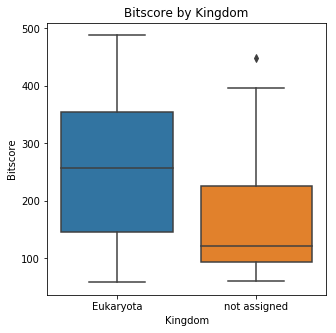

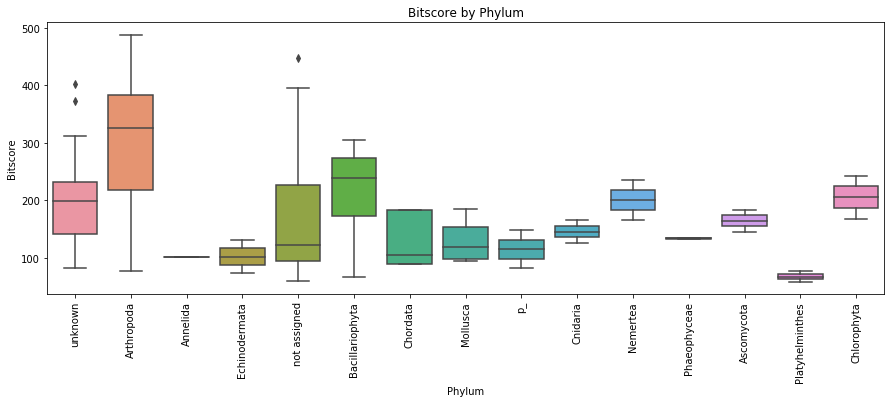

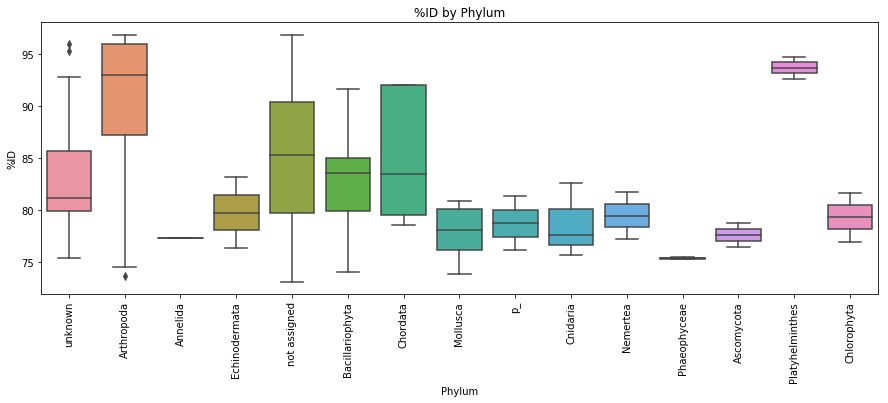

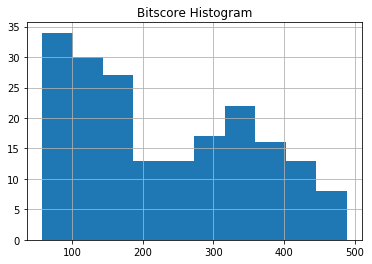

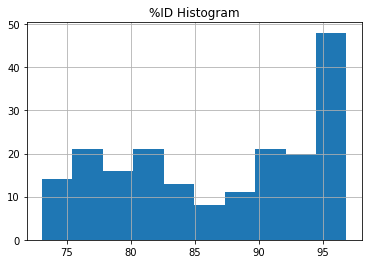

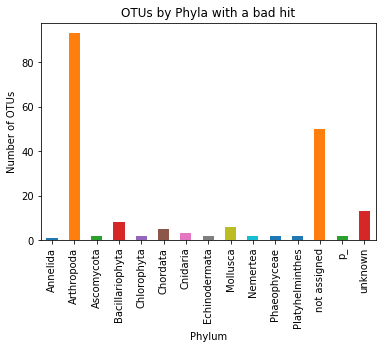

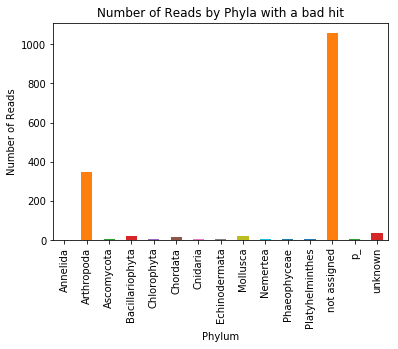

,eval,bitscore,%ID,align_len,Per_query,tot,count
Phylum,,,,,,,
Annelida,1.692160e-23,102,77.33,172,54.952077,2.0,1
Arthropoda,1.016138e-15,27913,8394.55,21527,7460.102546,346.0,93
Ascomycota,2.772130e-36,328,155.11,570,182.108626,6.0,2
Bacillariophyta,6.172830e-13,1706,661.87,2049,654.632588,21.0,8
Chlorophyta,5.916290e-43,410,158.58,589,188.178914,8.0,2


In [258]:
'''# Look at OTUs with bad hits:
df= MBq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['OTU'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['hit_def'].str.split('|').str[1]
df.set_index('MB_OTU', inplace=True)
df=df.join(seq_COI)
df['seqlen'] = df['repseq'].str.len()
print('Total OTUs with Hits:',len(df.index))
#tot_otus = len(raw_COI.index) #total OTUs blasted
print('Total OTUs Blasted:',len(raw_COI.index))
print('Total Filtered OTUs Blasted:',len(raw_COI_filt.index))
df['Per_query'] = df['align_len']/ df['seqlen'] *100

#remove OTUs that were filtered out
cols = list(raw_COI_filt)
df= df.join(raw_COI_filt)
df['tot'] = df[cols].sum(axis=1)
df.drop(cols, inplace=True, axis=1)
df=df.sort_values('tot')
df=df.loc[df['tot']!=0]
print('Total OTUs with Hits minus Filtered OTUs:',len(df.index))
tot_otus = len(raw_COI_filt.index) #total non-filtered OTUs blasted

#"good" hits; >95% query coverage, >97% sequence identity
df=df.loc[df['Per_query']<95]
df=df.loc[df['%ID']<97]
print('Total OTUs with Hits that don\'t qualify as good:',len(df.index))
df= df[['eval', 'bitscore', '%ID', 'align_len', 'Per_query', 'tot', 'USEARCH_OTU']]
df=pd.concat([df, Ftaxa_COI_filt], axis=1, join='inner')
df =df.fillna('not assigned')
print(len(df.index))

df=df.loc[df['bitscore']>0]
print(len(df.index))

import seaborn as sns
plt.figure(figsize=[5,5])
ax= sns.boxplot(data=df, y='bitscore', x='Kingdom')
plt.title('Bitscore by Kingdom')
plt.ylabel('Bitscore')
plt.show()

plt.figure(figsize=[15,5])
ax= sns.boxplot(data=df, y='bitscore', x='Phylum')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#g.set_xticklabels(rotation=90, labels=df['Class'].tolist())
plt.title('Bitscore by Phylum')
plt.ylabel('Bitscore')
plt.show()

plt.figure(figsize=[15,5])
ax= sns.boxplot(data=df, y='%ID', x='Phylum')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#g.set_xticklabels(rotation=90, labels=df['Class'].tolist())
plt.title('%ID by Phylum')
plt.ylabel('%ID')
plt.show()

df['bitscore'].hist()
plt.title('Bitscore Histogram')
plt.show()
df['%ID'].hist()
plt.title('%ID Histogram')
plt.show()


df['count']=1
df=df.groupby('Phylum').sum()
df['count'].plot(kind='bar')
plt.title('OTUs by Phyla with a bad hit')
plt.ylabel('Number of OTUs')
plt.show()

df['tot'].plot(kind='bar')
plt.title('Number of Reads by Phyla with a bad hit')
plt.ylabel('Number of Reads')
plt.show()


df.head()'''

In [238]:
#look at OTUs that don't have bad + no hits all together

df= MBq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['OTU'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['hit_def'].str.split('|').str[1]
df.set_index('MB_OTU', inplace=True)
df=df.join(seq_COI)
df['seqlen'] = df['repseq'].str.len()
print('Total OTUs with Hits:',len(df.index))
#tot_otus = len(raw_COI.index) #total OTUs blasted
print('Total OTUs Blasted:',len(raw_COI.index))
print('Total Filtered OTUs Blasted:',len(raw_COI_filt.index))
df['Per_query'] = df['align_len']/ df['seqlen'] *100

#remove OTUs that were filtered out
cols = list(raw_COI_filt)
df= df.join(raw_COI_filt)
df['tot'] = df[cols].sum(axis=1)
df.drop(cols, inplace=True, axis=1)
df=df.sort_values('tot')
df=df.loc[df['tot']!=0]
print('Total OTUs with Hits minus Filtered OTUs:',len(df.index))
tot_otus = len(raw_COI_filt.index) #total non-filtered OTUs blasted

#"good" hits; >95% query coverage, >97% sequence identity
df=df.loc[df['Per_query']>=95]
df=df.loc[df['%ID']>=97]
df['good']=1
df1 = Ftaxa_COI_filt.copy()
#df1 = taxa_COI.copy()
df1.fillna('not_assigned', inplace=True)
print(len(Ftaxa_COI_filt.index))

df=pd.concat([df[['good']], df1], axis=1)
df=df.sort_index()
print(len(df.index))
#df=df.loc[df['Kingdom'].isna()==True]
df=df.loc[df['good']!=1]
df.drop('good', axis=1, inplace=True)
cols = list(raw_COI_filt)
df = pd.concat([df, raw_COI_filt], axis=1, join='inner')
df['tot']=df[cols].sum(axis=1)
df.drop(cols, axis=1, inplace=True)
df['count']=1
#df= df.groupby(levels).sum()
df= df.groupby(levels[:3]).sum()
df=df.sort_values('tot', ascending=False)
df=df.sort_values('count', ascending=False)
df


Total OTUs with Hits: 19614
Total OTUs Blasted: 42050
Total Filtered OTUs Blasted: 29414
Total OTUs with Hits minus Filtered OTUs: 19049
29414
29414


/Users/kpitz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



tot  count
Kingdom      Phylum          Class                             
not_assigned not_assigned    not_assigned          43921  10452
Eukaryota    Arthropoda      Hexanauplia          293575   5814
                             Malacostraca          72354   1093
             Cnidaria        Hydrozoa              58343    451
             Chaetognatha    Sagittoidea           15133    295
not assigned not assigned    not assigned           1865    236
Eukaryota    Arthropoda      Ostracoda              2136    184
             unknown         Dinophyceae           19735    173
             Mollusca        Gastropoda             6192    102
             Annelida        Polychaeta              373     29
             Bacillariophyta Coscinodiscophyceae      76     18
                             Fragilariophyceae        56     18
             unknown         unknown                  37     14
             Arthropoda      c_                      114     13
             Ctenophora      Tentaculata              26     12
             Chordata        Thaliacea                35     12
             Chlorophyta     Mamiellophyceae        1304     12
             Bacillariophyta c_                      166     11
             p_              c_                       42     11
             Bacillariophyta Bacillariophyceae        29     11
             unknown         Oomycetes                28     11
             Chordata        Appendicularia           34      8
             Phaeophyceae    unknown                  21      8
             Chordata        Actinopteri              18      7
             Bryozoa         Gymnolaemata            796      7
             Arthropoda      unknown                  21      6
             Ascomycota      Eurotiomycetes           14      5
             Arthropoda      Branchiopoda             14      5
             Chlorophyta     c_                      829      5
             Echinodermata   Asteroidea               10      4
...                                                  ...    ...
                             Ophiuroidea               6      3
             Mollusca        Cephalopoda               6      3
             Cnidaria        Anthozoa                  4      2
             Platyhelminthes Cestoda                   5      2
             Nemertea        Pilidiophora              5      2
             Bacillariophyta Mediophyceae             10      2
             Ctenophora      Nuda                     11      2
             Echinodermata   Holothuroidea             8      2
             Chlorophyta     unknown                   6      1
             Ascomycota      Taphrinomycetes           2      1
             Cnidaria        unknown                   2      1
                             Scyphozoa                 2      1
             Annelida        c_                        2      1
             unknown         Cryptophyta               2      1
             Apicomplexa     c_                        2      1
             unknown         Oligohymenophorea         2      1
             Ascomycota      Dothideomycetes           2      1
             unknown         Polycystinea              2      1
                             Synurophyceae             2      1
             Apicomplexa     Conoidasida               2      1
             Basidiomycota   Microbotryomycetes        2      1
             Hemichordata    Enteropneusta             2      1
             Ascomycota      Sordariomycetes           3      1
             unknown         Raphidophyceae            3      1
             Arthropoda      Collembola                3      1
             Platyhelminthes unknown                   3      1
                             Trematoda                 3      1
             Ascomycota      Leotiomycetes             4      1
             unknown         Dictyochophyceae          4      1
             Ctenophora      c_                        2      1

[66 rows x 2 columns

[('Filt', 'Kingdom'), ('Filt', 'Phylum'), ('Filt', 'Class'), ('Filt', 'Order'), ('Filt', 'Family'), ('Filt', 'Genus'), ('Filt', 'Species'), ('norm', 'Kingdom'), ('norm', 'Phylum'), ('norm', 'Class'), ('norm', 'Order'), ('norm', 'Family'), ('norm', 'Genus'), ('norm', 'Species'), 'repseq']
['aaataggtgctggtacaagatgggatctccgccccctgctgggtcgaagaaggaggtgttgaagttgcgatcggtcaacaatatagtgatagcacctgctaacacaggtagagacaggaggagcaggatagcagtcagtaggacggatcagacgaagaggggcatgagctccattgtcatgccctctccttttatgtttgtgatagtggtgataaagttagccgagcccaggatcctccttacaccggctagatgtagagaaaagataccgagatcaacggcactcccgggatgccccagggttgacagc', 'aaataggtgctgatatagaattggatcccctttccccccctggcatcatagaaggatgtattaaggttttgatcggtgagtagcattgtaatcgctcctgccaggacaggtaaagatagtaataatagcactgctgtgataagaacatcccatgaaaaaagaagcatttgatcaaacaatatgccaagaatacgaagattgataatggttctaataaaatttaccacccctaaaatatatctcacccctgctaagtgaagagaaaaaatagcaaaatctagcgaccctcctgcatgagcaatattcccagaga', 'aaataggtactgatataaaatggggtcacctcctccgttggattcataaaatgaggtgtttagatttcggtcagtaag

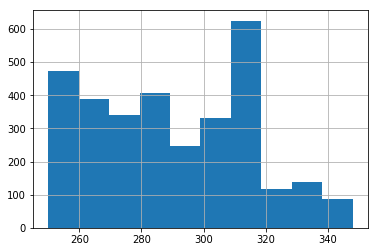

,"(Filt, Kingdom)","(Filt, Phylum)","(Filt, Class)","(Filt, Order)","(Filt, Family)","(Filt, Genus)","(Filt, Species)","(norm, Kingdom)","(norm, Phylum)","(norm, Class)","(norm, Order)","(norm, Family)","(norm, Genus)","(norm, Species)",repseq,len
OTU,,,,,,,,,,,,,,,,
OTU_100062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,aaataggtgctggtacaagatgggatctccgccccctgctgggtcg...,310
OTU_100086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,aaataggtgctgatatagaattggatcccctttccccccctggcat...,313
OTU_100301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,aaataggtactgatataaaatggggtcacctcctccgttggattca...,313
OTU_100862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,aaatagatgttgatacagtataacgtctccgcctccagtgggatca...,315
OTU_101270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,aaatacataagatcctcacctcccccagagtcataaaaagatgtat...,300
OTU_101273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,aaataattgttgatataaaacaggatcaccttatccttcagcttca...,313
OTU_101284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,aaataataattgggccaatataaaatttaggccaaaataaaaatat...,303
OTU_101286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,aaataataattgggacaatagaaaatttaggccaaaataaaaattt...,307
OTU_1020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,aaataggtgctggtatagaatagggtcaccccccccgttggagtcg...,313


In [262]:
df= pd.concat([Ftaxa_COI_filt, taxa_COI], keys=['Filt', 'norm'], axis=1, join='inner')

df = pd.concat([df, seq_COI], axis=1, join='inner')
df=df.loc[df[('Filt', 'Kingdom')].isna()==True]
#df=df.loc[df[('Filt', 'Kingdom')].isna()==False]
print(list(df))
df['len'] = df['repseq'].str.len()
df['len'].hist()
test=df['repseq'].tolist()
print(test[:3])
plt.show()
df

# Look at Blast results: USEARCH contigs as a query vs Banzai contigs as DB

In [52]:
#USEARCH data as a query, Banzai data as the database
filename = '/Users/kpitz/Projects/Gulf_of_California/Geller_MB_blastn/Gellerquery_MBdb_COI_blastn_092419.xml'
#filename = '/Users/kpitz/Projects/Gulf_of_California/Geller_MB_blastn/MBquery_Gellerdb_COI_blastn_092419.xml'

result_handle =open(filename)
blast_records= NCBIXML.parse(result_handle)
#Dictionary to store hits
hit_dict ={}
for blast_record in blast_records:
    #query = blast_record.query.split('|')[1]
    query = blast_record.query
    #print(query)
    hit_ID=0
    for alignment in blast_record.alignments:
        hit_ID+=1       #hit ID counter
        if hit_ID >20:
            continue
        key = (query, hit_ID)
        hsp = alignment.hsps[0] #only look at top hsp
        #set limits on evalue and bitscore and % Identity
        per_iden = hsp.identities/float(hsp.align_length)
        per_iden = (per_iden *100)
        per_iden = round(per_iden, 2)
        evalue = hsp.expect
        bitscore = int(hsp.bits)
        #alignment length
        align_len = hsp.align_length
        
        value = (evalue, bitscore, per_iden, alignment.hit_def, align_len)
        hit_dict[key]=value

print ('Done parsing Blast xml File!')
#Save blast result stats to file
Blast_Results = pd.DataFrame(hit_dict)
Blast_Results=Blast_Results.T
Blast_Results.columns = ['eval','bitscore', '%ID', 'hit_def', 'align_len']

Gellerq = Blast_Results.copy()
Gellerq


Done parsing Blast xml File!


eval bitscore  \
Geller_COI|OTU_1000|8|NaN_NaN_NaN_NaN_NaN_NaN      1   5.74164e-164      573   
                                                   2   1.27852e-140      496   
Geller_COI|OTU_1001|5|NaN_NaN_NaN_NaN_NaN_NaN      1   2.64359e-162      568   
Geller_COI|OTU_1002|324|NaN_NaN_NaN_NaN_NaN_NaN    1   5.74164e-164      573   
                                                   2   7.42728e-163      569   
                                                   3   1.24285e-160      562   
                                                   4   1.60772e-159      558   
                                                   5    5.7824e-159      556   
                                                   6   4.50181e-155      544   
                                                   7    5.9906e-134      473   
                                                   8   1.29674e-130      462   
                                                   9   1.29674e-130      462   
                                                   10  1.29674e-130      462   
                                                   11  1.29674e-130      462   
                                                   12  1.67744e-129      459   
                                                   13  6.03313e-129      457   
                                                   14  7.80435e-128      453   
                                                   15  2.80694e-127      451   
                                                   16  2.80694e-127      451   
                                                   17  2.80694e-127      451   
                                                   18  1.00956e-126      449   
                                                   19  1.30594e-125      446   
                                                   20  1.30594e-125      446   
Geller_COI|OTU_1003|160|NaN_NaN_NaN_NaN_NaN_NaN    1   2.64359e-162      568   
                                                   2   5.72238e-159      556   
                                                   3   2.05813e-158      555   
                                                   4   2.66236e-157      551   
                                                   5   6.09857e-114      407   
                                                   6    2.54476e-08       56   
                                                   7    2.54476e-08       56   
...                                                             ...      ...   
Geller_COI|OTU_99|2677|Arthropoda_Maxillopoda_C... 11  4.54854e-155      544   
                                                   12  4.54854e-155      544   
                                                   13  1.63594e-154      542   
                                                   14   5.8839e-154      540   
                                                   15   5.8839e-154      540   
                                                   16   5.8839e-154      540   
                                                   17  2.11623e-153      538   
                                                   18  2.11623e-153      538   
                                                   19  7.61131e-153      536   
                                                   20  2.73751e-152      534   
Geller_COI|OTU_9|8203|NaN_NaN_NaN_NaN_NaN_NaN      1   7.50438e-163      569   
                                                   2   2.69905e-162      568   
                                                   3   1.25575e-160      562   
                                                   4   1.25575e-160      562   
                                                   5   1.25575e-160      562   
                                                   6   1.25575e-160      562   
                                                   7   1.25575e-160      562   
                                                   8   1.25575e-160      562   
                                                   9   1.25575e

In [54]:
#get sequence length of USEARCH OTUs
df= Geller_COI.copy()
df.set_index('#OTU ID', inplace=True)
df=df[['Sequence']]
df['seqlen'] = df['Sequence'].str.len()
seqlen_Geller_COI = df.copy()
seqlen_Geller_COI.head()

,Sequence,seqlen
#OTU ID,,
OTU_1,CTCTCAGGTAATGTTGCCCACGCAGGAGGCTCCGTTGACTTTGCCA...,315
OTU_10,CTTTATTGAGTAACATTGCCCATGCTGGTGCATCAGTTGATTTTGC...,314
OTU_100,CGTTAAGAGGAAATTTAGCTCATGCAGGCGCATCTGTTGACTTTGC...,314
OTU_1000,CTTTATCAGTGGTAGGACACCCTGGGGGTGCGGTAGATATAGCAAT...,311
OTU_1001,CTCTTTCTGATTCGAAGTTCTCCGGTCAAGGTGTGGATTATTTACT...,308


In [56]:
df= Gellerq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['hit_def'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['OTU'].str.split('|').str[1]
df.set_index('USEARCH_OTU', inplace=True)
df=df.join(seqlen_Geller_COI)
print('Total OTUs with Hits:',len(df.index))
tot_otus = len(df.index)
df['Per_query'] = df['align_len']/ df['seqlen'] *100

#"good" hits; >95% query coverage, >97% sequence identity
df=df.loc[df['Per_query']>=95]
df=df.loc[df['%ID']>=95]
print('Total OTUs with Good Hits:',len(df.index))
good_otus = len(df.index)
print('Percent Hits with >95% query coverage, >95% sequence identity:', tot_otus/good_otus *100)
#look at hits to any filtered out MB OTUs:
df= df.reset_index().set_index('MB_OTU')
cols = list(raw_COI_filt)
df= df.join(raw_COI_filt)
df['tot'] = df[cols].sum(axis=1)
df.drop(cols, inplace=True, axis=1)
df=df.sort_values('tot')
df=df.loc[df['tot']==0]
print('Total OTUs with Good Hits to Filtered-out contigs:',len(df.index))
df.head()

Total OTUs with Hits: 1596
Total OTUs with Good Hits: 1596
Percent Hits with >95% query coverage, >95% sequence identity: 100.0
Total OTUs with Good Hits to Filtered-out contigs: 46


,USEARCH_OTU,OTU,Hit_number,eval,bitscore,%ID,hit_def,align_len,Sequence,seqlen,Per_query,tot
MB_OTU,,,,,,,,,,,,
OTU_104160,OTU_511,Geller_COI|OTU_511|155|NaN_NaN_NaN_NaN_NaN_NaN,1,1.2469e-165,579,100,DUP_104160;size=6;,313,CTTTAGCCTCTAACATTGCTCACGCAGGAGCTTCAGTTGACATGGG...,314,99.6815,0.0
OTU_94088,OTU_114,Geller_COI|OTU_114|278|NaN_NaN_NaN_NaN_NaN_NaN,1,3.47871e-166,580,100,DUP_94088;size=4;,314,CTCTTTCAGGGAATATTGCTCACGCAGGCTCATCAGTAGACGTTGC...,315,99.6825,0.0
OTU_1734,OTU_158,Geller_COI|OTU_158|309|NaN_NaN_NaN_NaN_NaN_NaN,1,2.69905e-162,568,99.36,DUP_1734;size=331;,313,CATTAAGAAGTCTCTTAAGTCATGAAGGTATTTCAGTTGATTTGGC...,314,99.6815,0.0
OTU_263,OTU_1407,Geller_COI|OTU_1407|2463|NaN_NaN_NaN_NaN_NaN_NaN,1,1.2469e-165,579,100,DUP_263;size=2359;,313,CTTTATCATCTAATCTTTCACATTCTGGATCTTCAGTAGATTTAGC...,314,99.6815,0.0
OTU_27270,OTU_1162,Geller_COI|OTU_1162|17|NaN_NaN_NaN_NaN_NaN_NaN,1,1.2469e-165,579,100,DUP_27270;size=13;,313,CTTTAGCAGGTCCTTTATATCATCCAGGTCCTTCGGTAGATCTTTT...,314,99.6815,0.0


In [275]:
#look at which OTUs are hit by USEARCH OTUs
df= Gellerq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['hit_def'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['OTU'].str.split('|').str[1]
df.set_index('USEARCH_OTU', inplace=True)
df=df.join(seqlen_Geller_COI)
print('Total OTUs with Hits:',len(df.index))
tot_otus = len(df.index)
df['Per_query'] = df['align_len']/ df['seqlen'] *100

#"good" hits; >95% query coverage, >97% sequence identity
df=df.loc[df['Per_query']>=95]
df=df.loc[df['%ID']>=97]
print('Total OTUs with Good Hits:',len(df.index))
good_otus = len(df.index)
print('Percent Hits with >95% query coverage, >97% sequence identity:', tot_otus/good_otus *100)
#look at hits to any filtered out MB OTUs:
df= df.reset_index().set_index('MB_OTU')
df=pd.concat([df[['USEARCH_OTU','%ID', 'bitscore']], Ftaxa_COI_filt.fillna('un_ass')], axis=1, join='inner')
df['count'] = 1
#df = df.groupby(levels).sum()
df = df.groupby(levels[:3]).sum()
print(df.sum(axis=0))
df=df.sort_values('count', ascending=False)
df


Total OTUs with Hits: 1596
Total OTUs with Good Hits: 1596
Percent Hits with >95% query coverage, >97% sequence identity: 100.0
count    1550
dtype: int64


count
Kingdom      Phylum          Class                     
Eukaryota    Arthropoda      Hexanauplia            598
un_ass       un_ass          un_ass                 175
Eukaryota    Arthropoda      Malacostraca           139
             Cnidaria        Hydrozoa               106
             Mollusca        Gastropoda              89
not assigned not assigned    not assigned            72
Eukaryota    Annelida        Polychaeta              43
             unknown         Dinophyceae             30
             Chaetognatha    Sagittoidea             27
             Arthropoda      Ostracoda               20
             Chordata        Actinopteri             20
             Bacillariophyta Coscinodiscophyceae     18
             p_              c_                      16
             Bacillariophyta Bacillariophyceae       13
             Chordata        Thaliacea               11
             Mollusca        Bivalvia                10
             Ctenophora      Tentaculata             10
             Arthropoda      unknown                 10
             unknown         unknown                  9
             Echinodermata   Ophiuroidea              9
                             Asteroidea               7
             Phaeophyceae    unknown                  7
             Bryozoa         Gymnolaemata             7
             Mollusca        Cephalopoda              7
             Echinodermata   Echinoidea               6
             Bacillariophyta c_                       6
                             Mediophyceae             6
             Arthropoda      c_                       6
                             Branchiopoda             6
             Cnidaria        Anthozoa                 6
...                                                 ...
             Echinodermata   Holothuroidea            3
             Hemichordata    Enteropneusta            3
             Xenacoelomorpha Acoela                   2
             Chlorophyta     unknown                  2
             Echinodermata   c_                       2
             Nemertea        Enopla                   2
             Platyhelminthes c_                       2
             Rotifera        Monogononta              1
             unknown         Bangiophyceae            1
                             Chrysophyceae            1
                             Dictyochophyceae         1
                             Labyrinthulomycetes      1
                             Raphidophyceae           1
                             Synurophyceae            1
             Annelida        Clitellata               1
             Nemertea        Pilidiophora             1
             Cnidaria        Scyphozoa                1
             Chordata        Mammalia                 1
                             Aves                     1
             Chlorophyta     Trebouxiophyceae         1
             Brachiopoda     unknown                  1
             Basidiomycota   Microbotryomycetes       1
             Ascomycota      c_                       1
                             Sordariomycetes          1
                             Saccharomycetes          1
                             Leotiomycetes            1
                             Lecanoromycetes          1
                             Eurotiomycetes           1
                             Dothideomycetes          1
             Chordata        c_                       1

[65 rows x 1 columns]

In [280]:
#look at which OTUs are hit by USEARCH OTUs
df= Gellerq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['hit_def'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['OTU'].str.split('|').str[1]
df.set_index('USEARCH_OTU', inplace=True)
df=df.join(seqlen_Geller_COI)
print('Total OTUs with Hits:',len(df.index))
tot_otus = len(df.index)
df['Per_query'] = df['align_len']/ df['seqlen'] *100

#"good" hits; >95% query coverage, >97% sequence identity
df=df.loc[df['Per_query']>=95]
df=df.loc[df['%ID']>=97]
print('Total OTUs with Good Hits:',len(df.index))
good_otus = len(df.index)
print('Percent Hits with >95% query coverage, >97% sequence identity:', tot_otus/good_otus *100)
#look at hits to any filtered out MB OTUs:
df= df.reset_index().set_index('MB_OTU')
df=pd.concat([df[['USEARCH_OTU','%ID', 'bitscore']], Ftaxa_COI_filt.fillna('un_ass')], axis=1, join='inner')
df['count'] = 1
MB_match = df.index
print(len(MB_match))
MB_match = list(set(MB_match))
print(len(MB_match))
print(MB_match[:10])
#df.reset_index(inplace=True)
#df.drop_duplicates('index', inplace=True)
#df=df.sort_values('index')
df=df.loc[df['Species']=='Clausocalanus furcatus']
df


Total OTUs with Hits: 1596
Total OTUs with Good Hits: 1596
Percent Hits with >95% query coverage, >97% sequence identity: 100.0
1550
1550
['OTU_66227', 'OTU_63173', 'OTU_39103', 'OTU_40404', 'OTU_32918', 'OTU_37659', 'OTU_11946', 'OTU_1996', 'OTU_15436', 'OTU_1672']


,USEARCH_OTU,%ID,bitscore,Kingdom,Phylum,Class,Order,Family,Genus,Species,count
OTU_24835,OTU_129,100,579,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus,1


In [281]:
#USEARCH contigs clustered at 95% identity for COI so much less sequence diversity for the same species

In [282]:
df = Ftaxa_COI_filt.copy()
df=df.loc[df['Species']=='Clausocalanus furcatus']
df


,Kingdom,Phylum,Class,Order,Family,Genus,Species
OTU,,,,,,,
OTU_10547,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_13003,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_13521,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_142452,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_142674,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_142695,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_142729,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_145693,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_180,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
